# This notebook demonstrates the use of Naive Bayes differential privacy on deidentified data using: Adult Census Data

In [1]:
from statistics import stdev, mean
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

# Load all necessary packages
import sys
import time
sys.path.append("../")
import numpy as np
from tqdm import tqdm
import pandas as pd

from aif360.datasets import BinaryLabelDataset
from aif360.datasets.artificial_all import Artificial_all

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.preproc_artificial_all import \
    load_preproc_artificial_all_deid, load_preproc_artificial_all_og, load_preproc_data_german_deid4, load_preproc_data_german_full
from aif360.algorithms.preprocessing.adult_data_deid_debias import *


from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

import diffprivlib.models as dp


from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics



In [2]:
# config_file_path = "config_adult_data_sub.yml"
# cfg = pm_utils.load_config_file(config_file_path)
# #preproc_algo = cfg['input']['preproc_algo']

# input_file = cfg['input']['ori_file']
# print(input_file)

In [5]:
biased_class = 'Gender'
privileged_groups = [{biased_class: 1}]
unprivileged_groups = [{biased_class: 0}]
target = 'Income Binary'
numeric = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
file_loc = '/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/adult-og/'
file_name = 'adult_og'

og_german = load_preproc_artificial_all_og(file_name, file_loc, protected_attributes = [biased_class])
og_german_df = og_german.convert_to_dataframe()[0]
og_german_df = scale_it(og_german_df, numeric)
og_X_train, og_X_test, og_y_train, og_y_test = split_it(og_german_df, target)
og_X_test

,age,education_num,capital_gain,capital_loss,hours_per_week,native_country,Ethnicity,Gender,workclass=Federal-gov,workclass=Local-gov,...,occupation=Protective-serv,occupation=Sales,occupation=Tech-support,occupation=Transport-moving,relationship=Husband,relationship=Not-in-family,relationship=Other-relative,relationship=Own-child,relationship=Unmarried,relationship=Wife
22858,0.563787,-0.438098,0.314743,-0.218783,-0.078121,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
41161,-0.722350,1.128781,-0.146728,-0.218783,-0.078121,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29681,0.261167,1.128781,-0.146728,-0.218783,1.587504,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
36833,-0.041454,1.912221,-0.146728,-0.218783,1.587504,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17592,0.412477,-0.438098,-0.146728,-0.218783,-0.078121,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21635,-0.949316,-0.046378,-0.146728,-0.218783,-0.078121,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13229,0.488132,-0.438098,-0.146728,-0.218783,-0.078121,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35113,-0.117109,-0.438098,-0.146728,-0.218783,-0.078121,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31237,0.185512,1.128781,-0.146728,-0.218783,-2.576558,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
comp_orig = True
test_type = 'test_on_DEID'
biased_class = 'Gender'
privileged_groups = [{biased_class: 1}]
unprivileged_groups = [{biased_class: 0}]

numeric = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

deid_list = ['og', 'deid4', 'deid8', 'deid16']
epsilons = [10.0, 5.0, 1.0, 0.1]

#matrix = pd.read_csv(r'/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected.csv', dtype=str)
file_loc = '/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/adult-og/'

indexer = []
deidr_list = []

accu_list = []
maj_acc_list = []
min_acc_list = []
min_chg_pos_outcome_list = []
maj_chg_pos_outcome_list = []
disp_imp_list = []
num_pos_outcome = []

accu_list_std_dev = []
maj_acc_list_std_dev = []
min_acc_list_std_dev = []
min_chg_pos_outcome_list_std_dev = []
maj_chg_pos_outcome_list_std_dev = []
disp_imp_list_std_dev = []
num_pos_outcome_std_dev = []

all_datasets = {}


tic = time.clock()

for deid in epsilons:
    eps = deid
    deid = 'og'

    file_name = 'adult_' + deid
    indexer.append(file_name)
    deidr_list.append(eps)
    origin = file_loc + file_name
        
    all_datasets[file_name] = {}
    all_datasets[file_name]['base_data'] = load_preproc_artificial_all_og(file_name, file_loc, protected_attributes = [biased_class])

    df = all_datasets[file_name]['base_data'].convert_to_dataframe()[0]
    print(df.head())

    
    validation = file_loc + 'validation/' + file_name + '_df_VALIDATION_dp_'
#     df.to_csv(validation, index=False)

    df = scale_it(df, numeric)

    validation = file_loc + 'validation/' + file_name + '_df_VALIDATION+SCALED_dp_'
#     df.to_csv(validation, index=False)

    accuracy = []
    accuracy_std_dev = []
    disparate = []
    disparate_std_dev = []
    min_acc = []
    min_acc_std_dev = []
    maj_acc = []
    maj_acc_std_dev = []
    min_change = []
    min_change_std_dev = []
    maj_change = []
    maj_change_std_dev = []
    num_pos = []
    num_pos_std_dev = []

    test = 10
    for i in range(test):
        X_train, X_test, y_train, y_test = split_it(df, target)
        if comp_orig:
            X_test = og_X_test
            y_test = og_y_test
            test_type = 'test_on_ORIG'
            
        if i == 0:
            df_test = X_test.copy()
            df_test['Income Binary'] = y_test.values
            test_set = file_loc + 'test/' + file_name + '_df_TEST_'
#             df_test.to_csv(test_set, index=False)
            
            df_train = X_train.copy()
            df_train['Income Binary'] = y_train.values
            train_set = file_loc + 'test/' + file_name + '_df_TRAIN_'
#             df_train.to_csv(train_set, index=False)
            
            
        num_pos_og, accuracy_test, accuracy_train, acc_min_test, acc_maj_test, min_chg_pos_outcome, maj_chg_pos_outcome, disp_imp_test = dif_priv_nb(X_train, X_test, y_train, y_test, protected_att=biased_class, epsilon=eps)

        accuracy.append(accuracy_test)
        disparate.append(disp_imp_test)
        min_acc.append(acc_min_test)
        maj_acc.append(acc_maj_test)
        min_change.append(min_chg_pos_outcome)
        maj_change.append(maj_chg_pos_outcome)
        num_pos.append(num_pos_og)


    accu_list.append(mean(accuracy))
    maj_acc_list.append(mean(min_acc))
    min_acc_list.append(mean(maj_acc))
    min_chg_pos_outcome_list.append(mean(min_change))
    maj_chg_pos_outcome_list.append(mean(maj_change))
    disp_imp_list.append(mean(disparate))
    num_pos_outcome.append(mean(num_pos))

    accu_list_std_dev.append(stdev(accuracy))
    maj_acc_list_std_dev.append(stdev(min_acc))
    min_acc_list_std_dev.append(stdev(maj_acc))
    min_chg_pos_outcome_list_std_dev.append(stdev(min_change))
    maj_chg_pos_outcome_list_std_dev.append(stdev(maj_change))
    disp_imp_list_std_dev.append(stdev(disparate))
    num_pos_outcome_std_dev.append(stdev(num_pos))
            
toc = time.clock()            
tic_toc = toc-tic       
            

matrix = pd.DataFrame({'dataset': indexer})
matrix['deid'] = deidr_list   
matrix['accu'] = accu_list
matrix['maj_accu'] = maj_acc_list
matrix['min_accu'] = min_acc_list
matrix['min_chg_pos_outcome'] = min_chg_pos_outcome_list
matrix['maj_chg_pos_outcome'] = maj_chg_pos_outcome_list
matrix['disp_imp'] = disp_imp_list
matrix['num_pos_outcome'] = num_pos_outcome

matrix['accu_std_dev'] = accu_list_std_dev
matrix['maj_accu_std_dev'] = maj_acc_list_std_dev
matrix['min_accu_std_dev'] = min_acc_list_std_dev
matrix['min_chg_pos_outcome_std_dev'] = min_chg_pos_outcome_list_std_dev
matrix['maj_chg_pos_outcome_std_dev'] = maj_chg_pos_outcome_list_std_dev
matrix['disp_imp_std_dev'] = disp_imp_list_std_dev
matrix['num_pos_outcome_std_dev'] = num_pos_outcome_std_dev

file_dest = '/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/'
file_name = file_dest + 'adult_data_combined' + str(tic_toc)
# matrix.to_csv(file_name, index=False)
print(f'COMPLETE IN: {tic_toc}')


    age  education_num  capital_gain  capital_loss  hours_per_week  \
0  50.0           13.0           0.0           0.0            13.0   
1  38.0            9.0           0.0           0.0            40.0   
2  53.0            7.0           0.0           0.0            40.0   
3  28.0           13.0           0.0           0.0            40.0   
4  37.0           14.0           0.0           0.0            40.0   

   native_country  Ethnicity  Gender  workclass=Federal-gov  \
0             1.0        1.0     1.0                    0.0   
1             1.0        1.0     1.0                    0.0   
2             1.0        0.0     1.0                    0.0   
3             0.0        0.0     0.0                    0.0   
4             1.0        1.0     0.0                    0.0   

   workclass=Local-gov  ...  occupation=Sales  occupation=Tech-support  \
0                  0.0  ...               0.0                      0.0   
1                  0.0  ...               0.0       

/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data 

    age  education_num  capital_gain  capital_loss  hours_per_week  \
0  50.0           13.0           0.0           0.0            13.0   
1  38.0            9.0           0.0           0.0            40.0   
2  53.0            7.0           0.0           0.0            40.0   
3  28.0           13.0           0.0           0.0            40.0   
4  37.0           14.0           0.0           0.0            40.0   

   native_country  Ethnicity  Gender  workclass=Federal-gov  \
0             1.0        1.0     1.0                    0.0   
1             1.0        1.0     1.0                    0.0   
2             1.0        0.0     1.0                    0.0   
3             0.0        0.0     0.0                    0.0   
4             1.0        1.0     0.0                    0.0   

   workclass=Local-gov  ...  occupation=Sales  occupation=Tech-support  \
0                  0.0  ...               0.0                      0.0   
1                  0.0  ...               0.0       

/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data 

    age  education_num  capital_gain  capital_loss  hours_per_week  \
0  50.0           13.0           0.0           0.0            13.0   
1  38.0            9.0           0.0           0.0            40.0   
2  53.0            7.0           0.0           0.0            40.0   
3  28.0           13.0           0.0           0.0            40.0   
4  37.0           14.0           0.0           0.0            40.0   

   native_country  Ethnicity  Gender  workclass=Federal-gov  \
0             1.0        1.0     1.0                    0.0   
1             1.0        1.0     1.0                    0.0   
2             1.0        0.0     1.0                    0.0   
3             0.0        0.0     0.0                    0.0   
4             1.0        1.0     0.0                    0.0   

   workclass=Local-gov  ...  occupation=Sales  occupation=Tech-support  \
0                  0.0  ...               0.0                      0.0   
1                  0.0  ...               0.0       

/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data 

    age  education_num  capital_gain  capital_loss  hours_per_week  \
0  50.0           13.0           0.0           0.0            13.0   
1  38.0            9.0           0.0           0.0            40.0   
2  53.0            7.0           0.0           0.0            40.0   
3  28.0           13.0           0.0           0.0            40.0   
4  37.0           14.0           0.0           0.0            40.0   

   native_country  Ethnicity  Gender  workclass=Federal-gov  \
0             1.0        1.0     1.0                    0.0   
1             1.0        1.0     1.0                    0.0   
2             1.0        0.0     1.0                    0.0   
3             0.0        0.0     0.0                    0.0   
4             1.0        1.0     0.0                    0.0   

   workclass=Local-gov  ...  occupation=Sales  occupation=Tech-support  \
0                  0.0  ...               0.0                      0.0   
1                  0.0  ...               0.0       

/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data 

COMPLETE IN: 13.138445


In [7]:
df_imb_deid = matrix.copy()
accu_og_min = 0
accu_og_maj = 0
def accu_min_loss(x):
    global accu_og_min
    if x['deid'] == 'og' or x['deid'] == 10.0:
        accu_og_min = x['min_accu']
    cats = accu_og_min - x['min_accu'] 
    return cats

def accu_maj_loss(x):
    global accu_og_maj
    if x['deid'] == 'og' or x['deid'] == 10.0:
        accu_og_maj = x['maj_accu']
    cats = accu_og_maj - x['maj_accu']
    return cats
    
df_imb_deid['accu_maj_loss'] = df_imb_deid.apply(lambda x: accu_maj_loss(x), axis=1)
df_imb_deid['accu_min_loss'] = df_imb_deid.apply(lambda x: accu_min_loss(x), axis=1)
matrix = df_imb_deid.copy()
matrix

,dataset,deid,accu,maj_accu,min_accu,min_chg_pos_outcome,maj_chg_pos_outcome,disp_imp,num_pos_outcome,accu_std_dev,maj_accu_std_dev,min_accu_std_dev,min_chg_pos_outcome_std_dev,maj_chg_pos_outcome_std_dev,disp_imp_std_dev,num_pos_outcome_std_dev,accu_maj_loss,accu_min_loss
0,adult_og,10.0,0.765475,0.854578,0.721576,1.160643,0.973796,0.427473,498,0.026383,0.025309,0.029392,0.364630,0.251294,0.107585,0.0,0.000000,0.000000
1,adult_og,5.0,0.757492,0.850648,0.711596,1.092369,0.885659,0.443842,498,0.027497,0.031509,0.030924,0.503139,0.388888,0.100864,0.0,0.003930,0.009979
2,adult_og,1.0,0.757316,0.842430,0.715381,1.489960,0.959809,0.606158,498,0.019068,0.018632,0.026086,0.388388,0.257157,0.272289,0.0,0.012148,0.006194
3,adult_og,0.1,0.748073,0.837226,0.704148,1.390964,0.951275,0.517563,498,0.032777,0.032432,0.038787,0.552538,0.186144,0.165205,0.0,0.017351,0.017428


In [8]:
file_loc = '/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/adult-og/output/'
file_name = 'adult_table_dif_priv_' + test_type
dest = file_loc+file_name
matrix['De-identification Level'] = ['$\epsilon$=10','$\epsilon$=5', '$\epsilon$=1.0', '$\epsilon$=0.1']

matrix.set_index('De-identification Level', inplace=True)
new_df = matrix.filter(['accu', 'accu_std_dev','disp_imp', 'maj_chg_pos_outcome', 'min_chg_pos_outcome', \
                       'accu_maj_loss', 'accu_min_loss'], axis=1)
new_df.columns = ['Accuracy', 'Accuracy StdDev', "Disparate Impact", 'Fairness Loss Priv', \
                  'Fairness Loss Unpriv', 'Utility Loss Priv.', 'Utility Loss Unpriv']
# new_df.to_csv(dest)
new_df

,Accuracy,Accuracy StdDev,Disparate Impact,Fairness Loss Priv,Fairness Loss Unpriv,Utility Loss Priv.,Utility Loss Unpriv
De-identification Level,,,,,,,
$\epsilon$=10,0.765475,0.026383,0.427473,0.973796,1.160643,0.000000,0.000000
$\epsilon$=5,0.757492,0.027497,0.443842,0.885659,1.092369,0.003930,0.009979
$\epsilon$=1.0,0.757316,0.019068,0.606158,0.959809,1.489960,0.012148,0.006194
$\epsilon$=0.1,0.748073,0.032777,0.517563,0.951275,1.390964,0.017351,0.017428


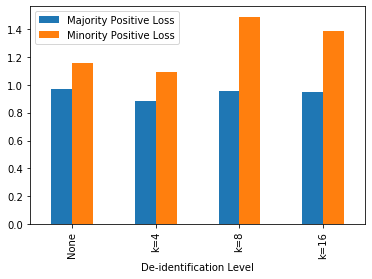

In [9]:
matrix['De-identification Level'] = ['None', 'k=4', 'k=8', 'k=16']
matrix.set_index('De-identification Level', inplace=True)
new_df = matrix.filter(['maj_chg_pos_outcome','min_chg_pos_outcome'], axis=1)
new_df.columns = ['Majority Positive Loss', "Minority Positive Loss"]
new_df.plot(kind='bar')

plt.savefig('/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/adult-og/adult_pos_loss_percentage_TEST_ON_ORIG_dp.png')
plt.show()

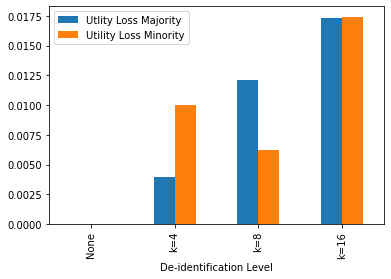

In [10]:
matrix['De-identification Level'] = ['None','k=4', 'k=8', 'k=16']
matrix.set_index('De-identification Level', inplace=True)
new_df = matrix.filter(['accu_maj_loss','accu_min_loss'], axis=1)
new_df.columns = ['Utlity Loss Majority', "Utility Loss Minority"]
new_df.plot(kind='bar')

plt.savefig('/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/adult-og/adult_utility_loss_TEST_ON_ORIG_dp.png')
plt.show()

In [11]:
df_log_reg = pd.read_csv(r'/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected_imb_dif_LOGREG_1657.62894')
df_gauss_NB = pd.read_csv(r'/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected_imb_dif_GAUSIAN_NB_311.2461709999999')
df_dp_NB = pd.read_csv(r'/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected_imb_dif_dif_priv_GAUSIAN_NB_712.423939')
df_dp_lr = pd.read_csv(r'/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected_imb_dif_DIF_PRIV_LOG_REG_936.4032239999999')

df_log_reg.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected_imb_dif_LOGREG_1657.62894'

In [ ]:
data_type = 'Artifical'
classifier = 'DP_Gauss_NB'
param = 'maj_pos'

if param == 'imbr':
    title = 'Imbalance Ratio'
if param == 'maj_pos':
    title = 'Majority Positive Percentage'
if param == 'min_pos':
    title = 'Minority Positive Percentage'
    
df_og = df_dp_NB
df_og['accu_maj_loss'] = [0] * len(df_og)
df_og['accu_min_loss'] = [0] * len(df_og)

imb_list = ['1', '2', '5', '10', '20', '50', '100']
dif_list = ['50_40', '50_20', '50_10', '50_5', '50_1', '40_20', '40_10', '40_5', '40_1', '20_10', '20_5', '20_1', '10_5', '10_1', '5_1']
deid_list = ['og', 'deid4', 'deid8', 'deid16']
epsilons = [0.1, 1.0, 5.0, 10.0]
dif_vals = [50, 40, 20, 10, 5, 1]

df_imb_deid = df_og.loc[:0]
#print(df_imb_deid)

for x in dif_vals:
    for deid in epsilons:
        df_imb1_og = df_og[(df_og[param] == int(x)) & (df_og['deid'] == deid)]
        df_imb1_og = df_imb1_og.reset_index()
        del df_imb1_og['index']

        temp_df = df_imb1_og.loc[:0]
        
        for column in df_imb1_og.columns:
            if column not in ['deid', 'dataset']:
                temp_df[column] = df_imb1_og[column].mean()
                
        df_imb_deid = pd.concat([df_imb_deid, temp_df], ignore_index=True, sort=False)


df_imb_deid = df_imb_deid.drop(0)

accu_og_min = 0
accu_og_maj = 0
def accu_min_loss(x):
    global accu_og_min
    if x['deid'] == 'og' or x['deid'] == 10.0:
        accu_og_min = x['min_accu']
    cats = x['min_accu'] - accu_og_min
    return cats

def accu_maj_loss(x):
    global accu_og_maj
    if x['deid'] == 'og' or x['deid'] == 10.0:
        accu_og_maj = x['maj_accu']
    cats = x['maj_accu'] - accu_og_maj
    return cats
    
df_imb_deid['accu_maj_loss'] = df_imb_deid.apply(lambda x: accu_maj_loss(x), axis=1)
df_imb_deid['accu_min_loss'] = df_imb_deid.apply(lambda x: accu_min_loss(x), axis=1)


df_imb_deid

In [ ]:
# og =df_imb_deid[df_imb_deid['deid'] == 'og']
# deid4 =df_imb_deid[df_imb_deid['deid'] == 'deid4']
# deid8 =df_imb_deid[df_imb_deid['deid'] == 'deid8']
# deid16 =df_imb_deid[df_imb_deid['deid'] == 'deid16']

og =df_imb_deid[df_imb_deid['deid'] == 10.0]
deid4 =df_imb_deid[df_imb_deid['deid'] == 5.0]
deid8 =df_imb_deid[df_imb_deid['deid'] == 1.0]
deid16 =df_imb_deid[df_imb_deid['deid'] == 0.1]

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel(title, fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='k', fontsize=16, fontweight='bold')

ax1.plot(og[param], og['accu'], color='r', marker='o')
ax1.plot(deid4[param], deid4['accu'], color='y', marker='o')
ax1.plot(deid8[param], deid8['accu'], color='g', marker='o')
ax1.plot(deid16[param], deid16['accu'], color='b', marker='o')

ax2 = ax1.twinx()
ax2.plot(og[param], og['disp_imp'], '--', color='r', marker='|')
ax2.plot(deid4[param], deid4['disp_imp'], '--', color='y', marker='|')
ax2.plot(deid8[param], deid8['disp_imp'], '--', color='g', marker='|')
ax2.plot(deid16[param], deid16['disp_imp'], '--', color='b', marker='|')
ax2.set_ylabel('Disparate-Impact', color='k', fontsize=16, fontweight='bold')

ax2.grid(True)

#file_loc = '/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Graphs/'
file_name = data_type + '_' + classifier + '_' + param + '_' + 'Accuracy_DisparateImpact.png'
destination = file_loc + file_name

plt.savefig(destination)

In [ ]:
from matplotlib import rc

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel(title, fontsize=16, fontweight='bold')
ax1.set_ylabel('Privacy-Fainess Loss', color='k', fontsize=16, fontweight='bold')

ax1.plot(og[param], og['maj_chg_pos_outcome'], color='r', marker='o', label= r'Priv Pos %: No Deid / $\epsilon$=10.0')
ax1.plot(og[param], og['min_chg_pos_outcome'], '--', color='r', marker='|', label= 'Unpriv Pos %: No Deid / $\epsilon$=10.0')

ax1.plot(deid4[param], deid4['maj_chg_pos_outcome'], color='y', marker='o',label= 'Priv Pos %: Deid k=4 / $\epsilon$=5.0')
ax1.plot(deid4[param], deid4['min_chg_pos_outcome'], '--', color='y', marker='|', label= 'Unpriv Pos %: Deid k=4 / $\epsilon$=5.0')

ax1.plot(deid8[param], deid8['maj_chg_pos_outcome'], color='g', marker='o', label= 'Priv Pos %: Deid k=8 / $\epsilon$=1.0')
ax1.plot(deid8[param], deid8['min_chg_pos_outcome'], '--', color='g', marker='|', label= 'Unpriv Pos %: Deid k=8 / $\epsilon$=1.0')

ax1.plot(deid16[param], deid16['maj_chg_pos_outcome'], color='b', marker='o', label= 'Priv Pos %: Deid k=16 / $\epsilon$=0.1')
ax1.plot(deid16[param], deid16['min_chg_pos_outcome'], '--', color='b', marker='|', label= 'Unpriv Pos %: Deid k=16 / $\epsilon$=0.1')
legend = plt.legend(loc=2, prop={'size': 15}, ncol=4, framealpha=1, shadow=True, borderpad=1)
#ax2 = ax1.twinx()
ax1.axis('off')

#ax2.set_ylabel('Achieved Minority Positive Percentage', color='k', fontsize=16, fontweight='bold')
#ax2.yaxis.set_tick_params(labelsize=5)
#ax1.grid(True)

def export_legend(legend, filename="legend.png", expand=[-1,-1,1,1]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    dest = file_loc + filename
    fig.savefig(dest, dpi="figure", bbox_inches=bbox)

file_loc = '/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Graphs/'
file_name = data_type + '_' + classifier + '_' + param + '_' + 'Privacy_Fainess_Loss.png'
destination = file_loc + file_name
leg_dest = file_loc + 'legend.png'
#plt.savefig(destination)
export_legend(legend)

In [ ]:
param

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel(title, fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy Loss: Privileged Unprivileged', color='k', fontsize=16, fontweight='bold')

ax1.plot(og[param], og['accu_maj_loss'], color='r', marker='o')
ax1.plot(deid4[param], deid4['accu_maj_loss'], color='y', marker='o')
ax1.plot(deid8[param], deid8['accu_maj_loss'], color='g', marker='o')
ax1.plot(deid16[param], deid16['accu_maj_loss'], color='b', marker='o')
ax1.plot(og[param], og['accu_min_loss'], '--', color='r', marker='|')
ax1.plot(deid4[param], deid4['accu_min_loss'], '--', color='y', marker='|')
ax1.plot(deid8[param], deid8['accu_min_loss'], '--', color='g', marker='|')
ax1.plot(deid16[param], deid16['accu_min_loss'], '--', color='b', marker='|')


#ax2 = ax1.twinx()

#ax2.set_ylabel('Achieved Minority Positive Percentage', color='k', fontsize=16, fontweight='bold')
#ax2.yaxis.set_tick_params(labelsize=5)
ax1.grid(True)

file_loc = '/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Graphs/'
file_name = data_type + '_' + classifier + '_' + param + '_' + 'Accuracy_Loss.png'
destination = file_loc + file_name

plt.savefig(destination)

#### Load dataset and set options

In [ ]:
from scipy.stats import pointbiserialr, spearmanr
df = matrix.copy()

df = df.fillna(0)

param_df = pd.DataFrame()
first = True

target_att = 'accu'
col_names = ['maj_pos', 'min_pos', 'imbr', 'deid']
metrics = ['accu', 'bal_accu', 'disp-imp', 'stat-par']

for met in metrics:
    param = []
    correlation = []
    abs_corr = []
    for c in col_names:
        if c != target_att:
            if len(df[c].unique()) <= 2:
                corr = spearmanr(df[met], df[c])[0]

            else:
                corr = spearmanr(df[met], df[c])[0]
            param.append(c)
            correlation.append(corr)
            abs_corr.append(abs(corr))
            
    if first == True:
        param_df = pd.DataFrame({'parameter': param, f'abs_corr_{met}': abs_corr})
        first = False
        #print(param_df)
    else:
        param_temp = pd.DataFrame({f'abs_corr_{met}': abs_corr})
#         print(param_df)
#         print(param_temp)    
        param_df = pd.concat([param_df, param_temp], axis=1)
    abs_corr = []

    param_df = param_df.sort_values(by=['abs_corr_accu'], ascending=False)
param_df = param_df.set_index('parameter')
param_df

### Find the optimal classification threshold from the validation set

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [ ]:
%matplotlib
import scipy.optimize
import functools
from numpy import *


df_og = df_deid16

fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')

X = df_og['imbr'].to_list()
Y = df_og['min_pos'].to_list()
Z = df_og['accu'].to_list()

X = [float(x) for x in X]
Y = [float(y) for y in Y]
Z = [float(z) for z in Z]

# points = np.array((X, Y, Z), dtype=float)

# points.shape

# print(points)

ax.axes.set_yticks(Y)

# ax = plt.gca()
# ax.hold(True)


ax.scatter(X, Y, Z, c ='r', marker='o')

ax.set_xlabel('imbr')
ax.set_ylabel('min_pos')
ax.set_zlabel('accu')

plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = wines['residual sugar']
ys = wines['fixed acidity']
zs = wines['alcohol']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('Residual Sugar')
ax.set_ylabel('Fixed Acidity')
ax.set_zlabel('Alcohol')

shape.colors

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

In [ ]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.show()

bingle = scatter3d(df_og['imbr'], df_og['difr'], df_og['accu'], )
xs = df_og['imbr']
ys = df_og['difr']
zs = df_og['accu']

print(xs.shape)
# col = [cm(float(i)/(40)) for i in xrange(40)]

col = np.arange(40)
ax.scatter(xs, ys, zs, s=20, c=col)



ax.set_xlabel('Imbalance')
ax.set_ylabel('Differential Positives')
ax.set_zlabel('Accuracy')

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|Adult||0.2674|
|German|0.6732|
|Compas|0.5148|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|0.2774|0.7625|0.7417|0.7443|0.4423|0.7430|
|German (Test)|0.6524|0.6460|0.9948|1.0852|0.6524|0.6460|0.3824|0.5735|
|Compas (Test)|0.6774|0.6562|0.6631|0.8342|0.6774|0.6342|0.6600|1.1062|



### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|-0.3281|-0.0266|0.7417|0.7443|-0.1991|-0.0395|
|German (Test)|0.6524|0.6460|0.0071|0.0550|0.6524|0.6460|-0.3278|-0.1944|
|Compas (Test)|0.6774|0.6562|-0.2439|-0.0946|0.6774|0.6342|-0.1927|0.1042|

In [ ]:
biased_class = 'Gender'
privileged_groups = [{biased_class: 1}]
unprivileged_groups = [{biased_class: 0}]

numeric = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

imb_list = ['1', '2', '5', '10', '20', '50', '100']
dif_list = ['50_40', '50_20', '50_10', '50_5', '50_1', '40_20', '40_10', '40_5', '40_1', '20_10', '20_5', '20_1', '10_5', '10_1', '5_1']
deid_list = ['og', 'deid4', 'deid8', 'deid16']

#matrix = pd.read_csv(r'/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected.csv', dtype=str)
file_loc = '/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/artificial/TESTY/'

indexer = []
imbr_list = []
deidr_list = []
maj_pos_list  = []
min_pos_list = []
accu_list = []
maj_acc_list = []
min_acc_list = []
min_chg_pos_outcome_list = []
maj_chg_pos_outcome_list = []
disp_imp_list = []
num_pos_outcome = []

accu_list_std_dev = []
maj_acc_list_std_dev = []
min_acc_list_std_dev = []
min_chg_pos_outcome_list_std_dev = []
maj_chg_pos_outcome_list_std_dev = []
disp_imp_list_std_dev = []
num_pos_outcome_std_dev = []

all_datasets = {}


tic = time.clock()
for imbr in imb_list:
    print(f'imbr: {imbr}')
    for difr in dif_list:
        for deid in deid_list:
            file_name = imbr + '_' + difr + '_' + deid
            indexer.append(file_name)
            imbr_list.append(imbr)
            maj_pos_list.append(int(difr.split('_')[0]))
            min_pos_list.append(int(difr.split('_')[1]))
            deidr_list.append(deid)
            origin = file_loc + file_name

            if deid == 'og':      
                all_datasets[file_name] = {}
                all_datasets[file_name]['base_data'] = load_preproc_artificial_all_og(file_name, file_loc, protected_attributes = [biased_class])
            else:
                all_datasets[file_name] = {}
                all_datasets[file_name]['base_data'] = load_preproc_artificial_all_deid(file_name, file_loc, protected_attributes = [biased_class])


            df = all_datasets[file_name]['base_data'].convert_to_dataframe()[0]
            #print(df.head())
            
            df = scale_it(df, numeric)
            

            accuracy = []
            accuracy_std_dev = []
            disparate = []
            disparate_std_dev = []
            min_acc = []
            min_acc_std_dev = []
            maj_acc = []
            maj_acc_std_dev = []
            min_change = []
            min_change_std_dev = []
            maj_change = []
            maj_change_std_dev = []
            num_pos = []
            num_pos_std_dev = []

            test = 10
            for i in range(test):
                #print(f'imbr: {imbr}, difr: {difr}')
                X_train, X_test, y_train, y_test = split_it(df) 
                num_pos_og, accuracy_test, accuracy_train, acc_min_test, acc_maj_test, min_chg_pos_outcome, maj_chg_pos_outcome, disp_imp_test = gaussian_nb(X_train, X_test, y_train, y_test)

                accuracy.append(accuracy_test)
                disparate.append(disp_imp_test)
                min_acc.append(acc_min_test)
                maj_acc.append(acc_maj_test)
                min_change.append(min_chg_pos_outcome)
                maj_change.append(maj_chg_pos_outcome)
                num_pos.append(num_pos_og)
                
                
                
            
            accu_list.append(mean(accuracy))
            maj_acc_list.append(mean(min_acc))
            min_acc_list.append(mean(maj_acc))
            min_chg_pos_outcome_list.append(mean(min_change))
            maj_chg_pos_outcome_list.append(mean(maj_change))
            disp_imp_list.append(mean(disparate))
            num_pos_outcome.append(mean(num_pos))
            
            accu_list_std_dev.append(stdev(accuracy))
            maj_acc_list_std_dev.append(stdev(min_acc))
            min_acc_list_std_dev.append(stdev(maj_acc))
            min_chg_pos_outcome_list_std_dev.append(stdev(min_change))
            maj_chg_pos_outcome_list_std_dev.append(stdev(maj_change))
            disp_imp_list_std_dev.append(stdev(disparate))
            num_pos_outcome_std_dev.append(stdev(num_pos))
            
toc = time.clock()            
tic_toc = toc-tic       
            

matrix = pd.DataFrame({'dataset': indexer})
matrix['imbr'] = imbr_list
matrix['maj_pos'] = maj_pos_list
matrix['min_pos'] = min_pos_list
matrix['deid'] = deidr_list   
matrix['accu'] = accu_list
matrix['maj_accu'] = maj_acc_list
matrix['min_accu'] = min_acc_list
matrix['min_chg_pos_outcome'] = min_chg_pos_outcome_list
matrix['maj_chg_pos_outcome'] = maj_chg_pos_outcome_list
matrix['disp_imp'] = disp_imp_list
matrix['num_pos_outcome'] = num_pos_outcome

matrix['accu_std_dev'] = accu_list_std_dev
matrix['maj_accu_std_dev'] = maj_acc_list_std_dev
matrix['min_accu_std_dev'] = min_acc_list_std_dev
matrix['min_chg_pos_outcome_std_dev'] = min_chg_pos_outcome_list_std_dev
matrix['maj_chg_pos_outcome_std_dev'] = maj_chg_pos_outcome_list_std_dev
matrix['disp_imp_std_dev'] = disp_imp_list_std_dev
matrix['num_pos_outcome_std_dev'] = num_pos_outcome_std_dev

file_dest = '/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/'
file_name = file_dest + 'all_data_matrix_exclude_protected_imb_dif_' + 'GAUSIAN_NB_' + str(tic_toc)
# matrix.to_csv(file_name, index=False)
matrix
print(f'COMPLETE IN: {tic_toc}')

In [ ]:
biased_class = 'Gender'
privileged_groups = [{biased_class: 1}]
unprivileged_groups = [{biased_class: 0}]

numeric = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

imb_list = ['1']#, '2', '5', '10', '20', '50', '100']
dif_list = ['50_40']#, '50_20', '50_10', '50_5', '50_1', '40_20', '40_10', '40_5', '40_1', '20_10', '20_5', '20_1', '10_5', '10_1', '5_1']
deid_list = ['og']#, 'deid4', 'deid8', 'deid16']

#matrix = pd.read_csv(r'/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/all_data_matrix_exclude_protected.csv', dtype=str)
file_loc = '/home/andrew/python-virtual-environments/AIF360/aif360/data/raw/artificial/TESTY/'

indexer = []
imbr_list = []
deidr_list = []
maj_pos_list  = []
min_pos_list = []
accu_list = []
maj_acc_list = []
min_acc_list = []
min_chg_pos_outcome_list = []
maj_chg_pos_outcome_list = []
disp_imp_list = []
num_pos_outcome = []

accu_list_std_dev = []
maj_acc_list_std_dev = []
min_acc_list_std_dev = []
min_chg_pos_outcome_list_std_dev = []
maj_chg_pos_outcome_list_std_dev = []
disp_imp_list_std_dev = []
num_pos_outcome_std_dev = []

all_datasets = {}


tic = time.clock()
for imbr in imb_list:
    print(f'imbr: {imbr}')
    for difr in dif_list:
        for deid in deid_list:
            file_name = imbr + '_' + difr + '_' + deid
            indexer.append(file_name)
            imbr_list.append(imbr)
            maj_pos_list.append(int(difr.split('_')[0]))
            min_pos_list.append(int(difr.split('_')[1]))
            deidr_list.append(deid)
            origin = file_loc + file_name

            if deid == 'og':      
                all_datasets[file_name] = {}
                all_datasets[file_name]['base_data'] = load_preproc_artificial_all_og(file_name, file_loc, protected_attributes = [biased_class])
            else:
                all_datasets[file_name] = {}
                all_datasets[file_name]['base_data'] = load_preproc_artificial_all_deid(file_name, file_loc, protected_attributes = [biased_class])


            df = all_datasets[file_name]['base_data'].convert_to_dataframe()[0]
            #print(df.head())
            
            df = scale_it(df, numeric)
            
            test = 1
            accuracy = []
            accuracy_std_dev = []
            disparate = []
            disparate_std_dev = []
            min_acc = []
            min_acc_std_dev = []
            maj_acc = []
            maj_acc_std_dev = []
            min_change = []
            min_change_std_dev = []
            maj_change = []
            maj_change_std_dev = []
            num_pos = []
            num_pos_std_dev = []
            
            for i in range(test):
                X_train, X_test, y_train, y_test = split_it(df) 
                num_pos_og, accuracy_test, accuracy_train, acc_min_test, acc_maj_test, min_chg_pos_outcome, maj_chg_pos_outcome, disp_imp_test = dif_priv_log(X_train, X_test, y_train, y_test)

                
                
                accuracy = []
                epsilons = np.logspace(-3, 1, 500)

                for eps in epsilons:
                    dp_clf = dp.LogisticRegression(epsilon=eps, data_norm=100)
                    dp_clf.fit(X_train, y_train)
                    accuracy.append(dp_clf.score(X_test, y_test))
                
#                 accuracy.append(accuracy_test)
#                 disparate.append(disp_imp_test)
#                 min_acc.append(acc_min_test)
#                 maj_acc.append(acc_maj_test)
#                 min_change.append(min_chg_pos_outcome)
#                 maj_change.append(maj_chg_pos_outcome)
#                 num_pos.append(num_pos_og)
                
                
                
            
#             accu_list.append(mean(accuracy))
#             maj_acc_list.append(mean(min_acc))
#             min_acc_list.append(mean(maj_acc))
#             min_chg_pos_outcome_list.append(mean(min_change))
#             maj_chg_pos_outcome_list.append(mean(maj_change))
#             disp_imp_list.append(mean(disparate))
#             num_pos_outcome.append(mean(num_pos))
            
#             accu_list_std_dev.append(stdev(accuracy))
#             maj_acc_list_std_dev.append(stdev(min_acc))
#             min_acc_list_std_dev.append(stdev(maj_acc))
#             min_chg_pos_outcome_list_std_dev.append(stdev(min_change))
#             maj_chg_pos_outcome_list_std_dev.append(stdev(maj_change))
#             disp_imp_list_std_dev.append(stdev(disparate))
#             num_pos_outcome_std_dev.append(stdev(num_pos))
            
toc = time.clock()            
tic_toc = toc-tic       
            

# matrix = pd.DataFrame({'dataset': indexer})
# matrix['imbr'] = imbr_list
# matrix['maj_pos'] = maj_pos_list
# matrix['min_pos'] = min_pos_list
# matrix['deid'] = deidr_list   
# matrix['accu'] = accu_list
# matrix['maj_accu'] = maj_acc_list
# matrix['min_accu'] = min_acc_list
# matrix['min_chg_pos_outcome'] = min_chg_pos_outcome_list
# matrix['maj_chg_pos_outcome'] = maj_chg_pos_outcome_list
# matrix['disp_imp'] = disp_imp_list
# matrix['num_pos_outcome'] = num_pos_outcome

# matrix['accu_std_dev'] = accu_list_std_dev
# matrix['maj_accu_std_dev'] = maj_acc_list_std_dev
# matrix['min_accu_std_dev'] = min_acc_list_std_dev
# matrix['min_chg_pos_outcome_std_dev'] = min_chg_pos_outcome_list_std_dev
# matrix['maj_chg_pos_outcome_std_dev'] = maj_chg_pos_outcome_list_std_dev
# matrix['disp_imp_std_dev'] = disp_imp_list_std_dev
# matrix['num_pos_outcome_std_dev'] = num_pos_outcome_std_dev

# file_dest = '/home/andrew/python-virtual-environments/Deid-Mitigation-Comparison/Outputs/'
# file_name = file_dest + 'all_data_matrix_exclude_protected_imb_dif_' + 'dif_priv_GAUSIAN_NB_' + str(tic_toc)
# matrix.to_csv(file_name, index=False)
# matrix
print(f'COMPLETE IN: {tic_toc}')
print(max(accuracy))
print(accuracy.index(max(accuracy)))
epsilons[accuracy.index(max(accuracy))]

import matplotlib.pyplot as plt
import pickle

pickle.dump((epsilons, accuracy), open("lr_accuracy_500.p", "wb" ) )

epsilons, accuracy = pickle.load(open("lr_accuracy_500.p", "rb"))

plt.semilogx(epsilons, accuracy, label="Differentially private")
#plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()